# Esercitazione 2: Content-to-Form

In questa esercitazione vedremo come implementare un sistema che, dato in input un insieme di definizioni, permette di individuare in modo automatico il concetto a cui esse si riferiscono. Essenzialmente il task, qui riferito come content-to-form, consiste in una **ricerca onomasiologica** automatica sfruttando un **sense repository** come *WordNet*.

Lo scopo dell'esercitazione risponde alla domanda "quanto è difficile identificare un concetto dalla sua definizione"?


In [1]:
import pandas as pd
from pathlib import Path

import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # for annoying NLTK warnings

import nltk
import numpy as np
from nltk.corpus import wordnet as wn

import src.content_to_form as ctof

[nltk_data] Downloading package wordnet to /home/prf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/prf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/prf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/prf/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Dati
I dati a disposizione (file `data/definitions.tsv`) consistono in 8 concetti ognuno con 12 definizioni date da 12 differenti annotatori.

In [2]:
concepts = pd.read_csv(Path("data/definitions.tsv"), sep="\t")

# annotated manually
true_concepts = [wn.synset('justice.n.01'), wn.synset('patience.n.01'),
                 wn.synset('greed.n.01'), wn.synset('politics.n.05'),
                 wn.synset('food.n.01'), wn.synset('radiator.n.02'),
                 wn.synset('vehicle.n.01'), wn.synset('screw.n.04 ')]

concepts.columns =  ["justice", "patience", "greed", "politics", "food", "radiator", "vehicle", "screw"]
concept_labels = [] # TODO put sysnet instead of lemma
concepts.head(5)

,justice,patience,greed,politics,food,radiator,vehicle,screw
0,"the concept of fairness, equality for all the ...",the quality of being able to wait for a long p...,quality of a person that is attached to money ...,the discipline that regulates territorial rules,something edible,item that emits warmth,rideable mean of transportation,item used to connect artificial parts together
1,condition of being morally correct,capacity to tolerate problems,excessive desire for something,activities associated with covernance of an area,subtance that animals eat,thing that radiated head,thing used for transporting people or goods,metal pin with raised helical thread running a...
2,abstract concept that refers to what is right,behavior of people inclined to bear unpleasant...,typical attitude of non generosity; behavior o...,abstract concept of governance inside a social...,thing needed to sustain a human being or an an...,object used to heat and raise temperature in a...,thing that provides a way to transport other t...,little metal object which can be inserted in a...
3,moral principle determining what is right,ability to tolerate stress over a period of time,intense desire to acquire or possess more than...,the activity of governing an entity and its af...,material used by organisms for maintaining the...,something that can produce heat,an artifact create to move things in space,metal object threaded used to produce other ar...
4,entity that allows compliance with the rules,ability to be quiet or tolerate problems,attachment to money,entity based on sets of principles that guide ...,one or more edible objects,heat diffusion object,object used as transportation,metal object used to fix componible elements


### Algoritmo

L'approccio algoritmico utilizzato, si basa sul principio di genus-differentia. L'ipotesi alla base dell'approccio consiste nel assumere che le definizioni seguono il pattern:
$$ \text{Concept}:\ \overbrace{\ldots\ldots\ldots}^{\text{genus}}\quad\overbrace{\ldots\ldots\ldots}^{\text{differentia}}$$

Ogni definizione dunque è composta da un *genus* ovvero il concetto target è espresso in termini di un suo concetto superordinato più generico, e da una *differentia* una serie di caratteristiche che permettono di caratterizzarlo e contraddistinguerlo da altri concetti.

Sorge però un problema principale, queste informazioni non sono codificate strutturalmente in WordNet! Riportiamo di seguito un [estratto](http://eprints-phd.biblio.unitn.it/1265/1/phd-thesis.pdf) che ha aiutato notevolmente nello sviluppo dell'algoritmo:


> Genus and differentia are not formally defined in WordNet. Notice that the synset and its genus ___should belong to the same grammatical category___. This is __not required for differentia__. For example, ricotta and its genus (cheese) in the following synset are nouns, while the differentia contains two adjectives soft and Italian

Partendo da questa osservazione, l'algoritmo implementato si articola nei seguenti steps:

1. Estrazione dei genus candidati basata su euristica.
    1. Pos Tagging ed estrazione lemmi NN e NNS
    2. Lesk-based WSD per l'identificazione del senso corretto per i lemmi dei genera estratti
    3. Creazione di un ranking basato su euristica di frequenza
2. Ricerca nella tassonomia di wordnet per ogni genus candidato
    1. Espansione del sottoalbero radicato nel synset del genus candidato
    2. Calcolo della signature dei synset iponimi
    3. Ricerca dell'iponimo la cui signature massimizza la similarità media con la signature del concetto target

Dobbiamo però specificare meglio cosa s'intende con **signature dei concetti** e come è stata calcolata la **similarità media**.
Si è scelto di utilizzare una rappresentazione vettoriale attraverso la **matrice document-term** e valutare la similarità tra signature del concetto (insieme di definizioni) e signature dell'iponimo (definizione + frasi di esempio) utilizzando la **similarità del coseno**.

Ricordando che la similarità del coseno è una funzione definita su due vettori, e nel nostro caso ad un concetto target abbiamo associati 12 vettori differenti (le definizioni), per ottenere un unico **valore aggregato** è stata calcolata la similarità in  modo pairwise:

$$  \overline{\operatorname{sim}}(\mathbf{v}_h,c)  = \frac{1}{12} \sum_{i=1}^{12}\operatorname{sim}(\mathbf{v}_h,\mathbf{v}_i)  \qquad \text{con} \qquad \operatorname{sim}(\mathbf{v}_h,\mathbf{v}_i) = \frac{\mathbf{v}_h\cdot\mathbf{v}_i}{||\mathbf{v}_h||\cdot||\mathbf{v}_i||}$$

Dove $\mathbf{v}_h$ è la rappresentazione vettoriale della signature dell'iponimo considerato e $\mathbf{v}_i$ è la rappresentazione vettoriale della $i$-esima definizione del concetto target 

data la signature del concetto target $c$ e un genus candidato $g\in G$, denotiamo con $H_g := \operatorname{hyponyms(g)}$ l'insieme degli iponimi estratti dall'algoritmo, il senso identificato dall'algoritmo per il concetto $c$ è dato da:

$$ \operatorname{argmax}_{\mathbf{v}_h \in H_g} \overline{\operatorname{sim}}(\mathbf{v}_h,c) $$


In [3]:
concept_name = 'justice'
concept_signature = concepts[concept_name]

candidate_genus = ctof.generate_genus_candidates(concept_signature)

print(f'Candidate genus ranking for "{concept_name}" concept:')
for k, genus_syn in enumerate(candidate_genus, start=1):
    print(f"{k}. {genus_syn.name()}")


Candidate genus ranking for "justice" concept:
1. concept.n.01
2. paleness.n.02
3. theme.n.03
4. right_field.n.01
5. equality.n.01
6. region.n.01
7. condition.n.03
8. abstraction.n.01
9. principle.n.01
10. entity.n.01
11. submission.n.02
12. rule.n.12
13. outline.n.02
14. front.n.03
15. code.n.03
16. law.n.06
17. community.n.06
18. multitude.n.03
19. court.n.06
20. timbre.n.01
21. point.n.22
22. opinion.n.02
23. application.n.07
24. jurisprudence.n.01
25. recognition.n.07
26. regard.n.06
27. people.n.03


Consideraimo ora il primo candidato nel ranking ed espandiamo il sottoalbero alla ricerca dei possibili iponimi che massimizzano la similarità con la signature del concetto target.

Vediamo un esempio sui primi 10 iponimi, in questo caso la lista non è un ranking.

In [4]:
best_candidate = candidate_genus[0]
hyponyms, hyponym_signatures =  ctof.hyponyms_signatures(best_candidate, max_search_depth=2)

MAX_HYPS = 10
for hyponym, hyponym_def in zip(hyponyms[:MAX_HYPS], hyponym_signatures[:MAX_HYPS]):
    print(f"{hyponym.name()}: {hyponym_def}")

concept.n.01: an abstract or general idea inferred or derived from specific instances
abstraction.n.01: a concept or idea not associated with any specific instance he loved her only in the abstract--not in person
category.n.02: a general concept that marks divisions or coordinations in a conceptual scheme
conceptualization.n.02: an elaborated concept
fact.n.04: a concept whose truth can be proved scientific hypotheses are not facts
hypothesis.n.02: a tentative insight into the natural world; a concept that is not yet verified but that if true would explain certain facts or phenomena a scientific hypothesis that survives experimental testing becomes a scientific theory he proposed a fresh theory of alkalis that later was accepted in chemical practices
law.n.03: a rule or body of rules of conduct inherent in human nature and essential to or binding upon human society
law.n.04: a generalization that describes recurring facts or events in nature the laws of thermodynamics
lexicalized_conce

Avendo a disposizione sia una signature per il concetto target che una signature per ogni iponimo candidato a rappresentare il concetto target possiamo calcolare la similarità tra le signature utilizzando una rappresentazione vettoriale.

Questa procedura viene implementata dalla funzione `content_to_form.compute_similarity_matrix` 

In [5]:
similarity_mat = ctof.compute_similarity_matrix(concept_signature, hyponym_signatures)

similarity_mat.shape

(12, 116)

Le dimensioni della matrice (12x116) rappresentano i valori di simalrità pairwise tra le 12 definizioni del concetto target e le 116 signature degli iponimi estratti dal sottoalbero radicato nel genus.

Text(0, 0.5, 'Concept Definition')

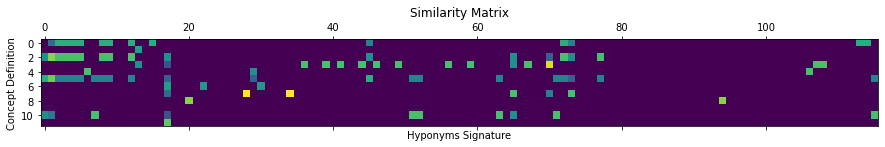

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(15,10))

ax.matshow(similarity_mat)
ax.set_title("Similarity Matrix")
ax.set_xlabel('Hyponyms Signature')
ax.set_ylabel('Concept Definition')

### Batch Processing

Eseguiamo l'intero algoritmo su tutti i concetti. Il risultato ottenuto è un ranking dei top-k sensi individuati dall'algoritmo. L'ordine nel ranking è dato dalla similarità media.

Viene inoltre riporta la distanza (shortest path nella tassonomia) tra i concetti individauti dall'algoritmo e il "true" concept (annotato manualmente).

In [7]:
MAX_SEARCH_DEPTH = 2
TOP_K_SENSES = 5


for concept_name, true_concept in zip(concepts.columns, true_concepts):
        
    concept_signature = concepts[concept_name]

    concept_signature = list(filter(lambda c: c is not np.NaN, concept_signature))
    top_k = ctof.content_to_form(concept_signature, TOP_K_SENSES, MAX_SEARCH_DEPTH)
    
    print(f"Concept: {concept_name}")
    print()
    for i, (sense, score) in enumerate(top_k, start=1):
        distance = sense.shortest_path_distance(true_concept)
        print(f"{i}. {sense.name()}; score {score:.4f}, distance {distance}")
    print("------------------------------------")

Concept: justice

1. right.n.01; score 0.1760, distance 12
2. right.n.01; score 0.1760, distance 12
3. right_field.n.01; score 0.1423, distance 13
4. side.n.01; score 0.1423, distance 11
5. abstraction.n.06; score 0.1053, distance 5
------------------------------------
Concept: patience

1. aptitude.n.01; score 0.2092, distance 10
2. adaptability.n.01; score 0.2092, distance 8
3. pons_asinorum.n.01; score 0.2092, distance 12
4. difficulty.n.03; score 0.1720, distance 8
5. capacity.n.08; score 0.1601, distance 10
------------------------------------
Concept: greed

1. hunger.n.02; score 0.2114, distance 2
2. thing.n.11; score 0.2091, distance 8
3. wish.n.02; score 0.2091, distance 12
4. pile.n.03; score 0.2059, distance 12
5. generosity.n.01; score 0.2059, distance 10
------------------------------------
Concept: politics

1. clubroom.n.01; score 0.1456, distance 14
2. nonprofit_organization.n.01; score 0.1324, distance 8
3. state.n.03; score 0.1099, distance 11
4. citizenry.n.01; score

Da un'analisi prettamente qualitativa, si può notare come in tutti i casi l'algoritmo non individua mai il senso corretto, una dinamica che però emerge è che alcuni dei sensi individuati sono nello stesso contesto semantico del concetto target ma certamente non possono essere identificati come suoi iponimi/iperonimi.

I pessimi risultati ottenuti sono imputabili principalmente alle seguenti motivazioni:

* Da un'analisi qualitativa delle definizioni, ben poche presentano una struttura genus-differentia, viene dunque meno l'assunzione alla base dell'approccio utilizzato.

* In alcuni casi (concetto 'greed') alcuni annotatori si riferivano a 'greed.n.01' altri a 'avarice.n.01' indicativo dello scarso intra-agreement tra annotatori, dinamica già vista nella prima esercitazione

* La conoscenza codificata in *WordNet* ha prettamente natura semantico-lessicale. Altre risorse come *Conceptnet* e la sua caratterstica di codificare conoscenza di tipo contestuale-associazionale avrebbe potuto aiutare notevolmente nel task in questione.